# General Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
%pdb off

from pyCascade import probePost, physics, quantities
from matplotlib import pyplot as plt
import numpy as np
import os
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.colors as mcolors

plt.rcParams['figure.dpi'] = 140
im_scaling = .75
plt.rcParams['figure.figsize'] = [6.4 * im_scaling, 4.8 * im_scaling]

############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)
plt.close('all')



Automatic pdb calling has been turned OFF


'/scratch/users/nbachand/Cascade/city_block_cfd'

'/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd'

# Runs

In [2]:
runs = {
    246: {'A': 45, 'WS': 2, 'C': 2, 'starts': [40000, 160000], 'stops': [119000, 240000], 'delT': [0, 5], 'SS': [True, True]},
    # 247: {'A': 45, 'WS': 4, 'C': 2, 'starts': [40000, 160000], 'stops': [119000, 240000], 'delT': [0, 5], 'SS': [True, True]},
    # 248: {'A': 0,  'WS': 2, 'C': 2, 'starts': [40000, 160000], 'stops': [119000, 240000], 'delT': [0, 5], 'SS': [True, True]},
    # 249: {'A': 0,  'WS': 4, 'C': 2, 'starts': [40000, 160000], 'stops': [119000, 240000], 'delT': [0, 5], 'SS': [True, True]},
    # 316: {'A': 45, 'WS': 2, 'C': 3, 'starts': [40000, 160000], 'stops': [119000, 240000], 'delT': [0, 5], 'SS': [True, True]},
    # 318: {'A': 45, 'WS': 4, 'C': 3, 'starts': [40000, 160000], 'stops': [119000, 240000], 'delT': [0, 5], 'SS': [True, True]},
    # 317: {'A': 0,  'WS': 2, 'C': 3, 'starts': [40000, 160000], 'stops': [119000, 240000], 'delT': [0, 5], 'SS': [True, True]},
    # 319: {'A': 0,  'WS': 4, 'C': 3, 'starts': [40000, 160000], 'stops': [119000, 240000], 'delT': [0, 5], 'SS': [True, True]},

    251: {'A': 45, 'WS': 2, 'C': 2, 'starts': [40000], 'stops': [110000], 'delT': [0], 'SS': [True]},
    252: {'A': 45, 'WS': 2, 'C': 2, 'starts': [40000], 'stops': [110000], 'delT': [0], 'SS': [True]},
}

plotFolder = f"{home_dir}/CHARLES/multiPlots/"

qoisOutputed = ["mag(u)_avg", "mag(u)_rms", "comp(u_rms,0)", "comp(u_rms,1)", "comp(u_rms,2)", "comp(u_avg,0)", "comp(u_avg,1)", "comp(u_avg,2)"]

In [3]:
allABLVolStats = {}
overWrite = False
for run in runs:
    C = runs[run]['C']
    category = f"config{C}"
    R = run % 100
    probes_dir = f'{scratch_dir}/CHARLES/{category}/R{R}/probes/probesOut'
    oak_probes_dir =  f'{home_dir}/CHARLES/{category}/R{R}/probes/probesOut_parquet/'
    print(R)
    starts = runs[run]['starts']
    stops = runs[run]['stops']
    delT = runs[run]['starts']
    SS = runs[run]['SS']
    if len(set([len(starts), len(stops), len(delT), len(SS)])) != 1:
        raise Exception(f"Run {runs} has array properties of different lengths")
    for j, start in enumerate(starts):
        stop = stops[j]
        ABLVolStatsPath = f"{oak_probes_dir}/../ABLVolStats-{start}to{stop}.csv"
        paths = [ABLVolStatsPath]
        for path in paths:
            if os.path.exists(path) == False or overWrite:
                print(f"Creating stats for {run} from step {stop}. Saving to {path}...")
                if j ==0:
                    print(f"reading probes from {oak_probes_dir}")
                    file_type = "csv"
                    probes = probePost.Probes(probes_dir, directory_parquet = oak_probes_dir, file_type = file_type, probe_type = "VOLUMETRIC_PROBES", flux_quants = qoisOutputed, name_pattern = "VolProbe")
                    # continue
                stats = probes.statistics(
                    names = probes.probe_names, 
                    steps = [stop],
                    quants = qoisOutputed,
                    processing = None,
                    parrallel=False
                )
                display(stats)
                stats.to_csv(ABLVolStatsPath)

        ABLVolStats = pd.read_csv(ABLVolStatsPath, index_col=0)
        for k, v in runs[run].items():
            if isinstance(v, list):
                ABLVolStats[k] = v[j]
            else:
                ABLVolStats[k] = v

        allABLVolStats[int(10*run + j)] = ABLVolStats

ABLVolStatsMI = pd.concat(allABLVolStats.values(), keys=allABLVolStats.keys())
            


46
51
52


In [4]:
def processVolProbeNames(s, pos = None):
    # Filter out any characters that are not digits, a decimal point, or a negative sign
    filtered = ''.join(c for c in s if c.isdigit() or c == '.' or c == '_')
    filtered = filtered.split('_')
    
    # Convert the filtered string to float
    if filtered:
        if pos is not None:
            return float(filtered[1][pos])
        else:
            return float(''.join(filtered[0]))

In [5]:
ABLFits = pd.DataFrame(columns=["uStar", "z0", "disp"])
for i, (k, stats) in enumerate(allABLVolStats.items()):
    # stats = df.copy()
    stats["lowerBound"] = stats.index.map(lambda s: processVolProbeNames(s))
    stats["xPos"] = stats.index.map(lambda s: processVolProbeNames(s, pos=0))
    stats["zPos"] = stats.index.map(lambda s: processVolProbeNames(s, pos=1))
    stats.sort_values(by = ["xPos", "zPos", "lowerBound"], inplace=True)

    upperBound = stats["lowerBound"].copy()
    upperBound = upperBound.shift(-1)

    if stats["C"].iloc[0] == 2:
        H = 77.3
    elif stats["C"].iloc[0] == 3:
        H = 116
    else:
        raise Exception("Configuration {category} not an option")
    upperBound.fillna(H, inplace = True)
    upperBound[upperBound == min(stats["lowerBound"])] = H
    stats["upperBound"] = upperBound
    stats.dropna(inplace=True)
    stats["y"] = (stats["lowerBound"] + stats["upperBound"]) / 2

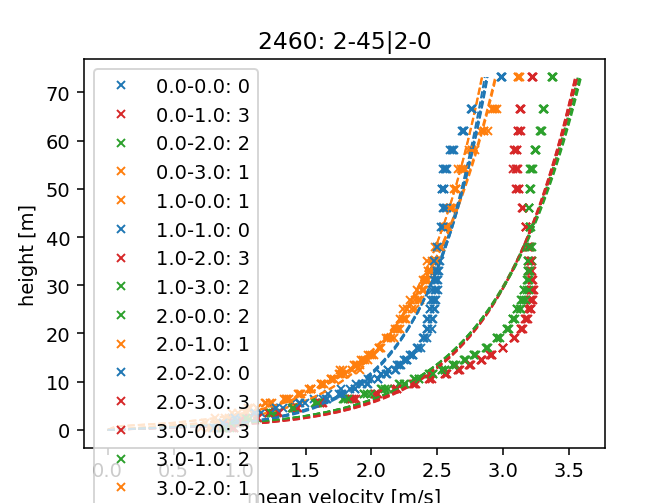

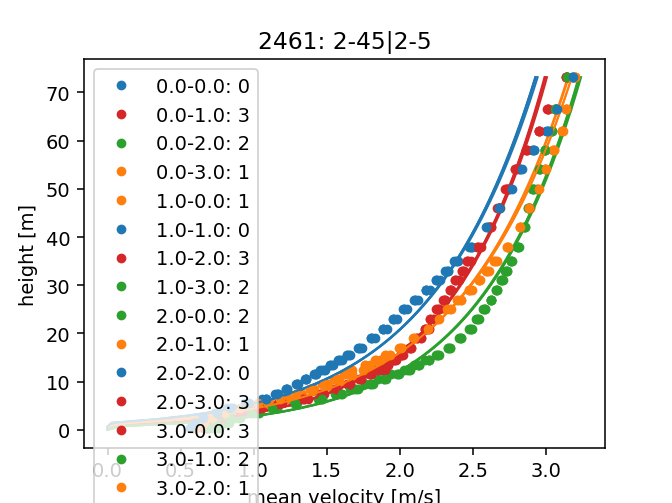

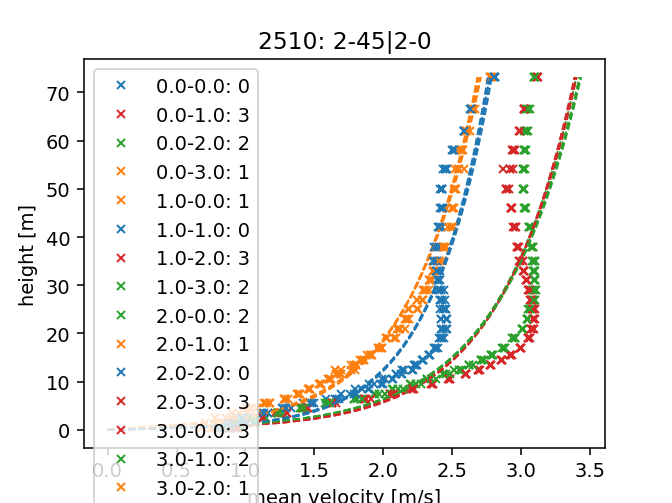

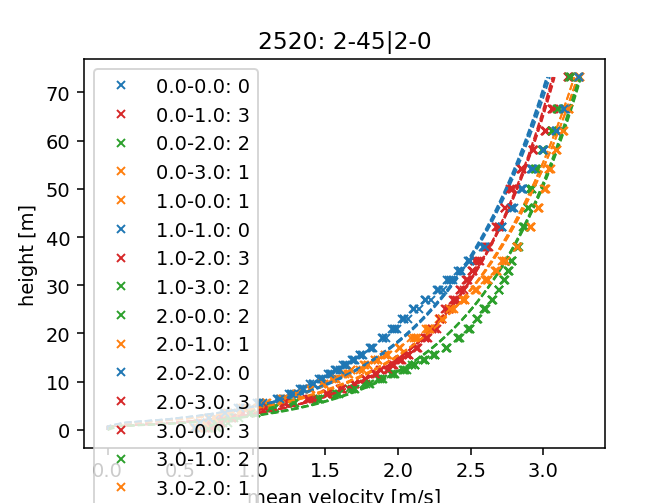

In [6]:
fmts = ['x', 'o']
styles = ['--', '-']
plt.close()
for i, (k, stats) in enumerate(allABLVolStats.items()):
    fig, ax = plt.subplots()
    A = stats["A"].iloc[0]
    C = stats["C"].iloc[0]
    WS = stats["WS"].iloc[0]
    delT = stats["delT"].iloc[0]
    ax.set_title(f"{k}: {C}-{A}|{WS}-{delT}")
    qty_vol = quantities.Qty()
    theta = stats["A"].iloc[0]
    thetaRad = theta / 180 * np.pi
    meanU = np.cos(thetaRad) * stats["comp(u_avg,0)"] + np.sin(thetaRad) * stats["comp(u_avg,2)"]
    statsMI = stats.set_index(["xPos", "zPos", "y"])
    c = 0
    fmt = fmts[int(k%2)]
    style = styles[int(k%2)]
    for xPos, dfx in statsMI.groupby(level=0):
        for zPos, df in dfx.groupby(level=1):
            qty_vol = quantities.Qty()
            # meanU = np.cos(thetaRad) * df["comp(u_avg,0)"] + np.sin(thetaRad) * df["comp(u_avg,2)"]
            meanU = df["mag(u)_avg"]
            # meanU = np.arctan(df["comp(u_avg,2)"] / df["comp(u_avg,0)"]) * 180 / np.pi
            qty_vol.meanU = meanU#.iloc[6:27]
            qty_vol.y = df.index.get_level_values(2).values#[6:27]
            if A == 45:
                id = int((xPos-zPos)%4)
            elif A == 0:
                id = int(zPos)
            ax = quantities.plot_ABL({f"{xPos}-{zPos}: {id}": qty_vol}, fit_disp=True, colorOffset=id, ax=ax, fmt = fmt, linestyle=style)
            c += 1

    # break
